In [21]:
# jupyter extensions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from tqdm import tqdm

import jax.numpy as jnp
import jax
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

from src.wgan import WGAN
from src.data import NumpyLoader, FlattenAndCast


In [43]:
# Hyperparameters
batch_size = 64
epoch = 2000
seed = 42
generator_learning_rate=5e-4
critic_learning_rate=5e-4 
n_critic=5
clipping_value=1e-2
latent_space_dim=100


In [24]:
# dataset
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_data_loader = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
data_dim = next(iter(training_data_loader))[0].shape[1]

In [25]:
wgan = WGAN(seed=seed, 
    generator_learning_rate=generator_learning_rate, 
    critic_learning_rate=critic_learning_rate,
    n_critic=n_critic,
    clipping_value=clipping_value,
    batch_size=batch_size,
    data_dim=data_dim,
    latent_space_dim=latent_space_dim)


In [44]:
from tqdm import tqdm
critic_loss = []
generator_loss = [] 
wasserstein_loss = []
for e in range(epoch):
    if e > 5: 
        wgan._n_critic = n_critic
    else: 
        wgan._n_critic = 100 # this trick is not in the paper but in the code
    with tqdm(enumerate(training_data_loader), desc=f"Epoch {e}") as pbar:
        for i, (x,y) in pbar:
            wgan._rng, sampling_rng = jax.random.split(wgan._rng)
            prior_data = jax.random.normal(sampling_rng, (wgan._batch_size, wgan._latent_space_dim))
            if i%wgan._n_critic == 0:
                wgan._learner_state, generator_logs = wgan.update_generator(wgan._learner_state, prior_data)
            else:
                wgan._learner_state, critics_logs = wgan.update_critic(wgan._learner_state, x, prior_data)
            
            if i%101==0 and i>0: 
                pbar.set_postfix(critic_loss=critics_logs['real_loss'], generator_loss=generator_logs['generated_loss'], wasserstein_loss=critics_logs['loss'])
                critic_loss.append(critics_logs['real_loss'])
                generator_loss.append(-generator_logs['generated_loss'])
                wasserstein_loss.append(-critics_logs['loss'])


Epoch 0: 938it [00:08, 105.11it/s, critic_loss=2730.6726, generator_loss=448.06332, wasserstein_loss=2475.7556]
Epoch 1: 938it [00:08, 105.34it/s, critic_loss=1462.7493, generator_loss=375.81244, wasserstein_loss=1151.2151]
Epoch 2: 938it [00:08, 105.93it/s, critic_loss=1506.7522, generator_loss=539.3838, wasserstein_loss=1506.688]  
Epoch 3: 938it [00:08, 107.16it/s, critic_loss=1932.0442, generator_loss=143.19572, wasserstein_loss=1364.1597]
Epoch 4: 938it [00:09, 103.40it/s, critic_loss=1210.5691, generator_loss=33.469696, wasserstein_loss=1084.0112]
Epoch 5: 938it [00:08, 104.62it/s, critic_loss=794.49414, generator_loss=2.1889966, wasserstein_loss=788.64343]
Epoch 6: 938it [00:08, 111.55it/s, critic_loss=1377.467, generator_loss=163.21487, wasserstein_loss=1373.2207]        
Epoch 7: 938it [00:08, 111.31it/s, critic_loss=1410.1265, generator_loss=48.47619, wasserstein_loss=910.377]      
Epoch 8: 938it [00:08, 111.60it/s, critic_loss=614.7965, generator_loss=6.0931864, wasserstein

KeyboardInterrupt: 

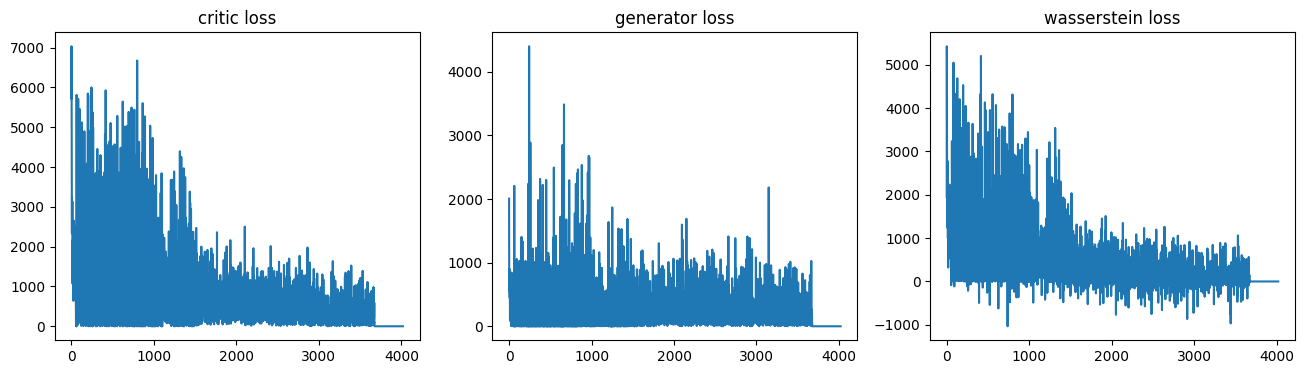

In [45]:
f, ax =plt.subplots(1,3, figsize=(16,4))

ax[0].plot(range(len(critic_loss)), critic_loss)
ax[0].set_title('critic loss')
ax[1].plot(range(len(critic_loss)), list(map(lambda x:-x,generator_loss)))
ax[1].set_title('generator loss')
ax[2].plot(range(len(critic_loss)), list(map(lambda x:-x,wasserstein_loss)))
ax[2].set_title('wasserstein loss')

plt.show()

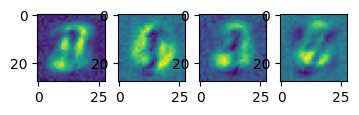

In [50]:
wgan._rng, sampling_rng = jax.random.split(wgan._rng)
prior_data = jax.random.normal(sampling_rng, (4, wgan._latent_space_dim))
imgs = wgan.generator(prior_data)
f, axes = plt.subplots(1, imgs.shape[0], figsize=(4, 2+4*imgs.shape[0]))
for ax, img in zip(axes,imgs):
    ax.imshow(img.reshape(28,28))

In [54]:
wgan.critic(imgs), wgan.critic(x[:4])

(DeviceArray([[0.05262105],
              [0.05262105],
              [0.05262105],
              [0.05262105]], dtype=float32),
 DeviceArray([[0.05262105],
              [0.05262105],
              [0.05262105],
              [0.05262105]], dtype=float32))

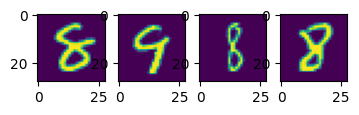

In [53]:
f, axes = plt.subplots(1, imgs.shape[0], figsize=(4, 2+4*imgs.shape[0]))
for ax, img in zip(axes,x[:4]):
    ax.imshow(img.reshape(28,28))